In [1]:
import pandas as pd
import re
from io import StringIO
from pathlib import Path


In [ ]:
"""
EMG Data Parser for Trigno CSV Files

This module provides functions to parse Trigno CSV files with proper column mapping
and sensor identification.
"""

import re
import pandas as pd
from io import StringIO
from pathlib import Path
from typing import List, Dict, Tuple, Optional


def _split_roster(line: str) -> List[str]:
    """
    Extract sensor names from roster line, removing IDs in parentheses.
    
    Args:
        line: Roster line from CSV file
        
    Returns:
        List of sensor names
    """
    # "forearm (58681), , AD (56093), , ..." -> ["forearm","AD","LD","PD","Tric","Lat","Pec","IMU"]
    parts = [p.strip() for p in line.split(',')]
    names = []
    for p in parts:
        if not p or p == '':
            continue
        # strip "(id)" if present
        names.append(re.sub(r'\s*\(\d+\)\s*', '', p))
    return names


def parse_trigno_csv_with_columns(
    path: str, 
    preferred_order: Optional[List[str]] = None
) -> Tuple[pd.DataFrame, Dict[str, str], List[str]]:
    """
    Parse Trigno CSV file with proper column mapping.
    
    Args:
        path: Path to the CSV file
        preferred_order: Optional list of 8 sensor names in preferred order (7 EMG + 'IMU')
    
    Returns:
        tuple: (dataframe with MultiIndex columns, metadata dict, roster list)
        
    Raises:
        RuntimeError: If file structure is unexpected
        ValueError: If preferred_order is invalid
    """
    path = Path(path)
    with path.open('r', encoding='utf-8', errors='ignore') as f:
        lines = [l.rstrip('\n') for l in f]

    # --- metadata until the roster line ---
    meta = {}
    i = 0
    while i < len(lines) and not lines[i].lower().startswith('forearm'):
        if ',' in lines[i]:
            k, v = [x.strip() for x in lines[i].split(',', 1)]
            meta[k.rstrip(':')] = v
        i += 1

    roster_line = lines[i]
    modes_line  = lines[i+1]
    header_line = lines[i+2]
    freq_line   = lines[i+3]
    data_lines  = lines[i+4:]

    roster = _split_roster(roster_line)  # export order
    # expected: 8 entries (7 EMG + 'IMU')
    if len(roster) < 8:
        raise RuntimeError(f"Unexpected roster: {roster}")

    # If user wants a custom logical order for EMG channels:
    if preferred_order is not None:
        # preferred_order should be 8 names with 'IMU' included once
        # we'll remap the 7 EMG names to this order; IMU stays 'IMU'
        emg_names_export = roster[:7]
        # Take the first 7 entries from preferred_order that are not 'IMU'
        emg_names_preferred = [n for n in preferred_order if n.upper() != 'IMU'][:7]
        if len(emg_names_preferred) != 7:
            raise ValueError("preferred_order must specify 7 EMG names plus 'IMU'.")
        # Replace roster EMG names with preferred order
        roster = emg_names_preferred + ['IMU']

    # Read the raw table (generic headers)
    raw_df = pd.read_csv(StringIO('\n'.join([header_line] + data_lines)), engine='python')
    raw_df.columns = [c.strip() for c in raw_df.columns]

    # Build an ordered spec of (sensor, subchannel, time_col, value_col, value_unit)
    spec = []

    # 7 EMG sensors - all labeled as "EMG 1" in the actual file
    # We need to map them sequentially based on the roster order
    emg_time_cols = [col for col in raw_df.columns if 'EMG 1 Time Series (s)' in col]
    emg_value_cols = [col for col in raw_df.columns if 'EMG 1 (mV)' in col]
    
    if len(emg_time_cols) != 7 or len(emg_value_cols) != 7:
        raise RuntimeError(f"Expected 7 EMG time and value columns, got {len(emg_time_cols)} and {len(emg_value_cols)}")
    
    # Map each EMG sensor to its columns
    for k in range(7):
        sensor = roster[k]
        t_col = emg_time_cols[k]
        v_col = emg_value_cols[k]
        spec.append((sensor, 'EMG', t_col, v_col, 'mV'))

    # IMU: ACC X/Y/Z, GYRO X/Y/Z (each has time + value)
    imu_pairs = [
        ('ACC X', r'ACC X Time Series \(s\)', r'ACC X \(G\)', 'G'),
        ('ACC Y', r'ACC Y Time Series \(s\)', r'ACC Y \(G\)', 'G'),
        ('ACC Z', r'ACC Z Time Series \(s\)', r'ACC Z \(G\)', 'G'),
        ('GYRO X', r'GYRO X Time Series \(s\)', r'GYRO X \(deg/s\)', 'deg/s'),
        ('GYRO Y', r'GYRO Y Time Series \(s\)', r'GYRO Y \(deg/s\)', 'deg/s'),
        ('GYRO Z', r'GYRO Z Time Series \(s\)', r'GYRO Z \(deg/s\)', 'deg/s'),
    ]
    for subch, t_pat, v_pat, unit in imu_pairs:
        t_col = next((c for c in raw_df.columns if re.fullmatch(t_pat, c, re.I)), None)
        v_col = next((c for c in raw_df.columns if re.fullmatch(v_pat, c, re.I)), None)
        if t_col is None or v_col is None:
            raise RuntimeError(f"Couldn't find IMU columns for {subch}.")
        spec.append(('IMU', subch, t_col, v_col, unit))

    # Build MultiIndex columns and new dataframe
    arrays = []
    data = {}

    # For each pair, create two MultiIndex columns: (sensor, sub, 'time_s') and (sensor, sub, 'value_<unit>')
    for sensor, sub, t_col, v_col, unit in spec:
        time_key  = (sensor, sub, 'time_s')
        value_key = (sensor, sub, f'value_{unit}')
        
        # Handle empty strings and convert to numeric
        # Handle duplicate column names by selecting the first occurrence
        if isinstance(raw_df[t_col], pd.DataFrame):
            time_series = pd.to_numeric(raw_df[t_col].iloc[:, 0], errors='coerce')
        else:
            time_series = pd.to_numeric(raw_df[t_col], errors='coerce')
            
        if isinstance(raw_df[v_col], pd.DataFrame):
            value_series = pd.to_numeric(raw_df[v_col].iloc[:, 0], errors='coerce')
        else:
            value_series = pd.to_numeric(raw_df[v_col], errors='coerce')
        
        arrays.append(time_key);   data[time_key]  = time_series
        arrays.append(value_key);  data[value_key] = value_series

    multi_cols = pd.MultiIndex.from_tuples(arrays, names=['sensor', 'channel', 'field'])
    out = pd.DataFrame(data, columns=multi_cols)

    return out, meta, roster


def collapse_to_single_time(df_multi: pd.DataFrame, imu_rate_hint: float = 370.3704) -> pd.DataFrame:
    """
    Collapse MultiIndex DataFrame to single time-based DataFrame.
    
    Args:
        df_multi: MultiIndex columns (sensor, channel, field) from the parser above.
                  e.g. ('Pec','EMG','time_s'), ('Pec','EMG','value_mV'), ..., ('IMU','ACC X','value_G')
        imu_rate_hint: Expected IMU sampling rate for tolerance calculation
        
    Returns:
        wide DataFrame with a single `time_s` column, EMG muscles in mV, IMU cols in G / deg/s.
    """
    # --- 1) Choose EMG master time (use the first EMG sensor's time column) ---
    emg_time_cols = [c for c in df_multi.columns if c[1] == 'EMG' and c[2] == 'time_s']
    if not emg_time_cols:
        raise ValueError("No EMG time columns found.")
    master_time_col = emg_time_cols[0]  # arbitrary first EMG time
    base = pd.DataFrame({'time_s': df_multi[master_time_col].astype('float64')})
    # Ensure strictly increasing (some exports repeat 0 at the very start)
    base = base.dropna().drop_duplicates(subset=['time_s']).sort_values('time_s').reset_index(drop=True)

    # --- 2) Add EMG values (one column per muscle) ---
    emg_val_cols = [c for c in df_multi.columns if c[1] == 'EMG' and c[2].startswith('value_')]
    for c in emg_val_cols:
        muscle = c[0]
        base[muscle + '_mV'] = pd.to_numeric(df_multi[c], errors='coerce').values

    # --- 3) Build IMU table (shared IMU time + 6 signals) ---
    imu_time_cols = [c for c in df_multi.columns if c[0] == 'IMU' and c[2] == 'time_s']
    if not imu_time_cols:
        # no IMU present; just return EMG-only
        return base

    imu_time = df_multi[imu_time_cols[0]].astype('float64')
    imu = pd.DataFrame({'imu_time_s': imu_time})
    # Collect value columns: ACC X/Y/Z (G) and GYRO X/Y/Z (deg/s)
    imu_val_cols = [c for c in df_multi.columns if c[0] == 'IMU' and c[2].startswith('value_')]
    for c in imu_val_cols:
        sub = c[1]              # e.g., 'ACC X'
        unit = c[2].split('_',1)[1]  # 'G' or 'deg/s'
        colname = f"{sub.replace(' ', '_')}_{unit}"  # e.g., ACC_X_G, GYRO_Y_deg/s
        imu[colname] = pd.to_numeric(df_multi[c], errors='coerce')

    imu = imu.dropna(subset=['imu_time_s']).drop_duplicates(subset=['imu_time_s']).sort_values('imu_time_s')

    # --- 4) Merge IMU onto EMG time by nearest timestamp ---
    # tolerance ~ half an IMU sample period
    tol = 0.5 / imu_rate_hint  # seconds
    wide = pd.merge_asof(
        base.sort_values('time_s'),
        imu.sort_values('imu_time_s'),
        left_on='time_s',
        right_on='imu_time_s',
        direction='nearest',
        tolerance=tol
    ).drop(columns=['imu_time_s'])

    return wide


def main(input_path : str):
    """Test the parser with the actual CSV file."""
    # Your preferred logical order:
    preferred = ['Pec','AD','LD','PD','Tric','Lat','forearm','IMU']  # EMG 7 + 'IMU'

    trigno_path = input_path

    try:
        # Parse the CSV file
        df_multi, metadata, roster_used = parse_trigno_csv_with_columns(
            trigno_path,
            preferred_order=None  # set to None to keep export order
        )

        print("Export/label order used:", roster_used)
        print("MultiIndex DataFrame shape:", df_multi.shape)
        print("MultiIndex columns (first 6):")
        print(df_multi.columns[:6])
        print("\nMetadata:")
        for k, v in metadata.items():
            print(f"  {k}: {v}")
        
        # Test the collapse function
        print("\n" + "="*50)
        print("Testing collapse_to_single_time function:")
        wide_df = collapse_to_single_time(df_multi)
        
        print(f"Collapsed DataFrame shape: {wide_df.shape}")
        print("Columns:", list(wide_df.columns))
        print("\nFirst 5 rows:")
        print(wide_df.head())
        print("\nData types:")
        print(wide_df.dtypes)

        return wide_df
            
    except Exception as e:
        print(f"Error parsing file: {e}")
        import traceback
        traceback.print_exc()


EMG_data_path = '/Users/riccardoconci/Local_documents/!CURRENT_RESEARCH/Personalising-Crutches/data_V2/raw/MIH15/2025-10-21/EMG'
wide_df = main(EMG_data_path)

Export/label order used: ['forearm', 'AD', 'LD', 'PD', 'Tric', 'Lat', 'Pec', 'IMU']
MultiIndex DataFrame shape: (93255, 26)
MultiIndex columns (first 6):
MultiIndex([('forearm', 'EMG',   'time_s'),
            ('forearm', 'EMG', 'value_mV'),
            (     'AD', 'EMG',   'time_s'),
            (     'AD', 'EMG', 'value_mV'),
            (     'LD', 'EMG',   'time_s'),
            (     'LD', 'EMG', 'value_mV')],
           names=['sensor', 'channel', 'field'])

Metadata:
  Application: Trigno Discover (1.7.0)
  Date/Time: 10/21/2025 9:29:54 AM
  Collection Length (seconds): 43.4119

Testing collapse_to_single_time function:
Collapsed DataFrame shape: (93255, 14)
Columns: ['time_s', 'forearm_mV', 'AD_mV', 'LD_mV', 'PD_mV', 'Tric_mV', 'Lat_mV', 'Pec_mV', 'ACC_X_G', 'ACC_Y_G', 'ACC_Z_G', 'GYRO_X_deg/s', 'GYRO_Y_deg/s', 'GYRO_Z_deg/s']

First 5 rows:
     time_s  forearm_mV     AD_mV     LD_mV     PD_mV   Tric_mV    Lat_mV  \
0  0.000101    0.003189 -0.018296 -0.013931 -0.003189 -0.0055

In [20]:
wide_df.head()

,time_s,forearm_mV,AD_mV,LD_mV,PD_mV,Tric_mV,Lat_mV,Pec_mV,ACC_X_G,ACC_Y_G,ACC_Z_G,GYRO_X_deg/s,GYRO_Y_deg/s,GYRO_Z_deg/s
0,0.000101,0.003189,-0.018296,-0.013931,-0.003189,-0.005539,0.054551,0.023163,-0.027344,-0.933106,0.314453,-8.47561,17.195122,-1.341463
1,0.000566,0.002518,-0.000504,-0.013596,-0.002182,-0.005539,0.079728,0.022492,-0.027344,-0.933106,0.314453,-8.47561,17.195122,-1.341463
2,0.001032,0.001175,0.008728,-0.012924,-0.002182,-0.006882,0.089799,0.022492,-0.027344,-0.933106,0.314453,-8.47561,17.195122,-1.341463
3,0.001497,0.000839,-0.005875,-0.012253,-0.003693,-0.006210,0.089799,0.023163,-0.027344,-0.933106,0.314453,-8.47561,17.195122,-1.341463
4,0.001963,0.001175,-0.020310,-0.012924,-0.005875,-0.004868,0.148211,0.021820,-0.027344,-0.933106,0.314453,-8.47561,17.195122,-1.341463


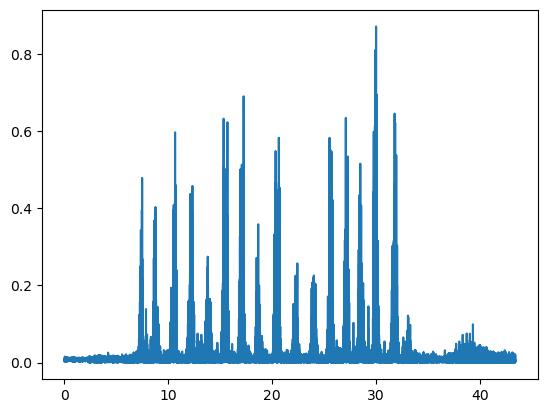